In [15]:
# Local Imports
import os
import pickle
import time
import datetime

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.stats import entropy
import pymc3
import board

import seaborn as sns

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
%load_ext tensorboard

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

import warnings
warnings.filterwarnings("ignore")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
start_time = time.time()
n = board.experiment()
print("--- %s seconds ---" % (time.time() - start_time))
print(n)
print(np.sum(n))

--- 0.20742511749267578 seconds ---
[  0.   0.   0.   0.   0.   0.   0.   0.   2.   2.   4.   4.  11.  21.
  30.  18.  50.  77.  94.  75. 115. 101.  99.  92.  74.  53.  29.  29.
  11.   7.   2.   0.]
1000.0


# Task 1: Simulator

In [3]:
nRows = 31

def simulator(alpha=0, s=0, n=1000):
    nslots = nRows+1 # Number of positions for marble in last row
    counts = np.zeros(nslots)
    
    nRight = np.zeros(n, dtype = int)
    M = np.zeros(n)
    
    rands = np.random.uniform(size = (n,nRows))

    for i in range(nRows):
        thres = 0.5 + alpha*M + s

        right = rands[:,i]<=thres
        nRight += right
        M = right - 0.5

    for i in range(nslots):
        counts[i] = (nRight == i).sum()        
    return counts

def simulator2(alpha=0, s=0, n=1000):
    
#     assert len(alpha) == len(s)
    alpha = alpha.reshape(-1,1)
    s = s.reshape(-1,1)
    
    nslots = nRows+1 # Number of positions for marble in last row
    counts = np.zeros((len(alpha), nslots))
    nRight = np.zeros((len(alpha), n), dtype = int)
    M = np.zeros((len(alpha), n))
    
    rands = np.random.uniform(size = (len(alpha),n,nRows))
    for i in range(nRows):
        thres = 0.5 + np.multiply(alpha,M) + s

        right = rands[:,:,i]<=thres
        nRight += right
        M = right - 0.5

    for i in range(nslots):
        counts[:,i] = (nRight == i).sum(axis=1)
        
    return counts
   
alpha = 0.2
s = 0.1
start_time = time.time()
for i in range(1000):
    simulator(alpha, s, n=1000)
print("--- %s seconds ---" % (time.time() - start_time))


alpha = np.random.rand(1000)*0.2
s = np.random.rand(1000)*0.1
start_time = time.time()
counts = simulator2(alpha, s, n=1000)

print("--- %s seconds ---" % (time.time() - start_time))
print(counts.shape)
    

--- 2.024198293685913 seconds ---
--- 2.898101329803467 seconds ---
(1000, 32)


In [4]:
a = np.array([1,2,3,4])
b = np.random.uniform(size=(4,4))
print(b)
print(np.multiply(a.reshape(-1,1),b))
print(np.multiply(a.reshape(-1,1),b)+a.reshape(-1,1))

[[0.3019273  0.59902477 0.77644993 0.4137046 ]
 [0.47953831 0.89637329 0.72976423 0.30990758]
 [0.91398101 0.83220127 0.85439357 0.91873186]
 [0.22240199 0.42885122 0.78502316 0.87687534]]
[[0.3019273  0.59902477 0.77644993 0.4137046 ]
 [0.95907661 1.79274658 1.45952846 0.61981517]
 [2.74194303 2.49660381 2.5631807  2.75619558]
 [0.88960795 1.71540486 3.14009262 3.50750134]]
[[1.3019273  1.59902477 1.77644993 1.4137046 ]
 [2.95907661 3.79274658 3.45952846 2.61981517]
 [5.74194303 5.49660381 5.5631807  5.75619558]
 [4.88960795 5.71540486 7.14009262 7.50750134]]


In [5]:
def gen_data(nData, alpha = None):
    alphaData = np.random.rand(nData)*0.5
    sData = np.random.rand(nData)*0.5 - 0.25
    y = np.zeros((nData, 2))
    X = np.zeros((nData, nRows+1))
    for i in range(nData):
        s = sData[i]
        y[i,1] = s
        if alpha != None:
            y[i,0] = alpha
            X[i,:] = simulator(alpha, s)
        else:
            a = alphaData[i]
            y[i,0] = a
            X[i,:] = simulator(a, s)     
    return X, y # return experiments and labels

def gen_exp_data(nData):
    X = np.zeros((nData, nRows+1))
    for i in tqdm(range(nData)):
        X[i,:] = board.experiment()
    return X


n_data = 300000
data_file = f'saved_structures/train_data_n={n_data}.p'

if os.path.isfile(data_file):
    print('Loading pickled training data')
    data = pickle.load(open( data_file, "rb" ))
    X, y = data
else:
    print('Generating training data')
    X,y = gen_data(n_data)
    data = (X,y)
    pickle.dump(data, open(data_file, "wb"))

Loading pickled training data


# Task 2: NN

In [6]:
def nn_model(X):
    input_shape = (X.shape[1],)
    model = keras.Sequential()
    # model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, input_shape=input_shape, activation="relu", kernel_initializer='random_normal'))
#     model.add(layers.Dense(16, activation="relu", kernel_initializer='random_normal'))
#     model.add(layers.Dense(8, activation="relu", kernel_initializer='random_normal'))
    # model.add(layers.Dense(3, activation="relu"))
    model.add(layers.Dense(
              2,  
#               kernel_initializer=initializers.RandomNormal(stddev=0.01), 
#               bias_initializer=initializers.RandomNormal(mean=1.0, stddev=0.1)
              bias_initializer=initializers.Zeros()
    ))
    #opt = keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mean_absolute_error'])
    return model
model = nn_model(X)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,122
Trainable params: 1,122
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_file = f'saved_structures/nn_model_n={n_data}'
history_file = f'saved_structures/training_history_n={n_data}.p'

if os.path.exists(model_file) and os.path.isfile(history_file):
    print('Loading models and history')
    model = keras.models.load_model(model_file)
    mae_history = pickle.load(open( history_file, "rb" ))
    
else: 
    print('Training NN and saving model and history')
    N = X[0,:].sum()
    print(N)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(x=X/N,
                        y=y,
                        epochs=200,
                        batch_size=1024,
                        validation_split=0.7,
                        verbose=0,
                        callbacks=[tensorboard_callback])
    model.save(model_file)
    mae_history = history.history
    pickle.dump(mae_history, open(history_file, "wb") )

Loading models and history


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
0.019287915900349617


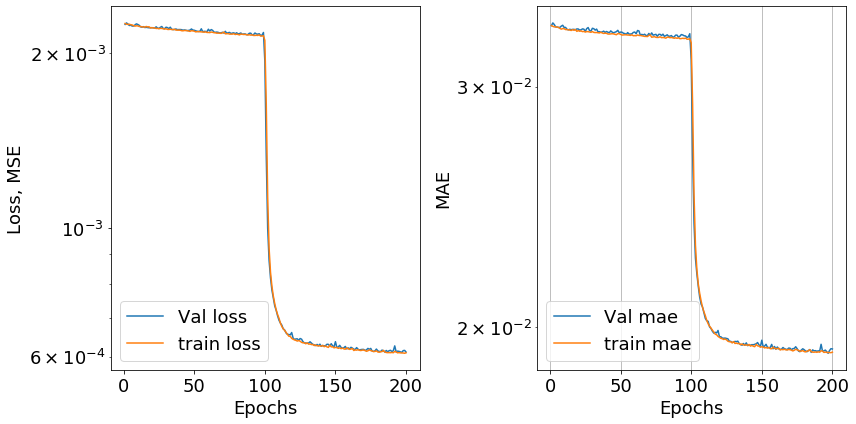

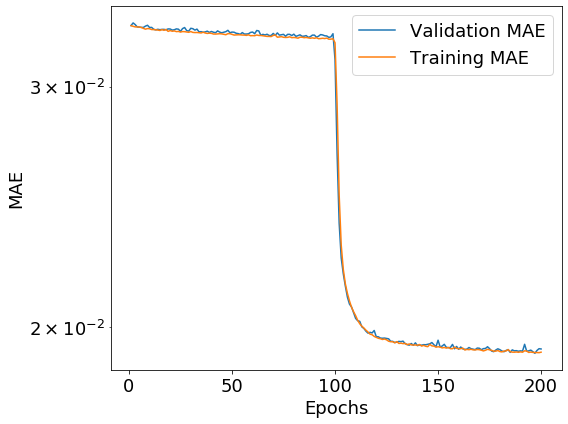

In [8]:
# Plot training history
print(mae_history.keys())
key = 'mean_absolute_error'
epochs = range(1, len(mae_history[key])+1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].plot(epochs, mae_history['val_loss'], label='Val loss')
axs[0].plot(epochs, mae_history['loss'], label='train loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss, MSE')
axs[0].legend(loc='best')
axs[0].set_yscale('log')

axs[1].plot(epochs, mae_history['val_'+key], label='Val mae')
axs[1].plot(epochs, mae_history[key], label='train mae')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend(loc='best')
axs[1].set_yscale('log')
axs[1].grid()

plt.tight_layout()

print(mae_history['val_'+key][-1])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs, mae_history['val_'+key], label='Validation MAE')
ax.plot(epochs, mae_history[key], label='Training MAE')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
ax.legend(loc='best')
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/NN_training.png')

## Task3

0.029902139693569217 0.018353721035642256
0.0009908280305472193 0.0021843693647535015


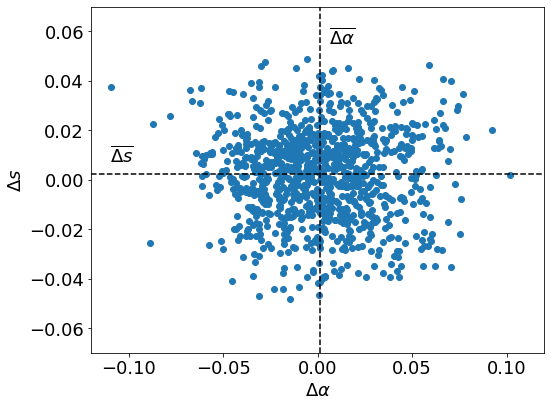

In [16]:
nData = 1000
    
y,labels = gen_data(nData)

theta = model.predict(y/1000)
error = theta - labels

alpha_mean = np.mean(error[:,0])
alpha_std = np.std(error[:,0])
s_mean = np.mean(error[:,1])
s_std = np.std(error[:,1])

# y_obs,_ = gen_data(nData, alpha = 0.2)
# y_obs = gen_exp_data(nData)
print(alpha_std, s_std)
print(alpha_mean, s_mean)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=error[:,0], y=error[:,1])
ax.axhline(s_mean, c='k', linestyle='--')
ax.axvline(alpha_mean, c='k', linestyle='--')
ax.text(-0.11, s_mean+0.005, r'$\overline{\Delta s}$')
ax.text(alpha_mean+0.005, 0.055, r'$\overline{\Delta \alpha}$')
ax.set_xlim(-0.12, 0.12)
ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\Delta\alpha$')
ax.set_ylabel(r'$\Delta s$')
plt.tight_layout()
plt.savefig('figures/NN_error.png')

In [13]:
##         
y_ob = y_obs[4,:]
theta_m = model.predict(y_ob.reshape(1,32)/1000)[0]

s_m = theta_m[1]
alpha_m = theta_m[0]
s_star = np.random.normal(loc = s_m, scale  = s_std)

alpha_star = np.random.rand()*0.5
y_star = simulator(alpha_star, s_star)

plt.plot(y_star)
plt.plot(y_ob)

n = 40
theta_pred = np.zeros((n,2))
stds = np.linspace(0,100,n)
for i, std in enumerate(stds):
    y = y_ob + np.random.normal(size = 32 ,loc = 0, scale = std)
    theta_pred[i,:] = model.predict(y.reshape(1,32)/1000)[0]


fig,ax = plt.subplots(figsize = (8,6))
ax.plot(stds, theta_pred[:,0]-0.2)


NameError: name 'y_obs' is not defined

In [11]:
def kernel(y, y_obs, h = 0.1, statistic = "KL"):
    N = y_obs.sum()
    if statistic == "KL":
        y_o = np.tile(y_obs, reps=(y.shape[0],1))
        entrop = 0.5*(entropy(qk = y, pk = y_o, axis=1) + entropy(pk = y, qk = y_o, axis=1))
        x = entrop/h
    elif statistic == "mean":
        grid = np.arange(0,32)
        y_mean =(y*grid).sum(axis=1)/N
        y_obs_mean = (y_obs*grid).sum()/N
        x = np.abs((y_mean - y_obs_mean))/h
    elif statistic == "std":
        grid = np.arange(0,32)
        y_mean =(y*grid).sum(axis=1)/N
        y_sq = (grid*y**2).sum(axis=1)/N
        y_std = np.sqrt(y_sq - y_mean**2)
        
        y_obs_mean = (y_obs*grid).sum()/N
        y_obs_sq = (grid*y_obs**2).sum()/N
        y_obs_std = np.sqrt(y_obs_sq - y_obs_mean**2)
        
        delta = y_obs_std - y_std
        x = np.abs(delta)/h
    elif statistic == "mean_std":
        grid = np.arange(0,32)
        y_mean =(y*grid).sum(axis=1)/N
        y_sq = (grid*y**2).sum(axis=1)/N
        y_std = np.sqrt(y_sq - y_mean**2)
        
        y_obs_mean = (y_obs*grid).sum()/N
        y_obs_sq = (grid*y_obs**2).sum()/N
        y_obs_std = np.sqrt(y_obs_sq - y_obs_mean**2)
        
        delta_mean = y_mean - y_obs_mean
        delta_std = y_obs_std - y_std
        x = np.sqrt(delta_mean**2 + delta_std**2)/h
    elif statistic == "euc":
        deltasq = ((y-y_obs)/N)**2
        x = np.sqrt(deltasq.sum(axis=1))/h
    elif statistic == "NN":
        theta_obs = model.predict(y_obs.reshape(1,32)/N)[0]
        theta = model.predict(y/N)
        delta = (theta - theta_obs) 
        x = np.sqrt(delta[:,0]**2 + delta[:,1]**2)/h
    elif statistic == "NN_no_s":
        theta_obs = model.predict(y_obs.reshape(1,32)/N)[0]
        theta = model.predict(y/N)
        delta = (theta - theta_obs) 
        x = np.sqrt(delta[:,0]**2)/h
    elif statistic == "WSD":
        x = np.zeros(y.shape[0])
        for i, y_i in enumerate(y):
            x[i] = sc.stats.wasserstein_distance(y_i,y_obs)/h
    elif statistic == "ED":
        x = np.zeros(y.shape[0])
        for i, y_i in enumerate(y):
            x[i] = sc.stats.energy_distance(y_i,y_obs)/h
    
    sigma = 1/np.sqrt(2*np.pi) # Set sigma so that K(0) = 1 
    return np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

def kernel_multiple_data(y, y_obs, h = 0.1, statistic = "NN"):
    N = y_obs[0,:].sum()
    if statistic == "NN":
        theta_obs = model.predict(y_obs/N)
        theta = model.predict(y.reshape(y.shape[0]*y.shape[1],y.shape[2])/N)
        theta = theta.reshape(y.shape[0], y.shape[1], theta.shape[1])
#         delta = (theta[:,:,0] - theta_obs[:,0])**2
#         x = np.sqrt(np.mean(delta, axis=1))/h
        x = (theta[:,:,0].mean(axis=1) - np.mean(theta_obs[:,0]))/h
    if statistic == 'mean_std':
        y_mean = np.mean(y, axis=2)
        y_obs_mean = np.mean(y_obs, axis=1)
        y_std = np.std(y, axis=2)
        y_obs_std = np.std(y_obs, axis=1)
        delta_mean = (y_mean - y_obs_mean)
        delta_std = (y_std - y_obs_std)
        x = np.sqrt(np.mean(delta_mean**2 + delta_std**2, axis=1))/h
    if statistic == "mean_NN":
        y_mean = np.mean(y, axis=1)
        y_obs_mean = np.mean(y_obs, axis=0)
        return kernel(y_mean, y_obs_mean, h=h, statistic='NN')
    
    sigma = 1/np.sqrt(2*np.pi) # Set sigma so that K(0) = 1 
    return np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)


def ABC_MCMC(y_obs, prior, h=0.1, statistic = 'euc', max_iter = 50, sim_iter=1, s_std = 0.01, alpha_std = 0.01):
    alpha = []
    N = y_obs[0,:].sum()
    for i, y_ob in enumerate(y_obs):
        theta_m = model.predict(y_ob.reshape(1,32)/N)[0]
        s_m = theta_m[1]
        alpha_m = theta_m[0]
        s_star = np.random.normal(loc = s_m, scale  = s_std, size=max_iter)
        
        alpha_star = prior.rvs(size=max_iter)

        y_star = simulator2(alpha_star, s_star, n=1000*sim_iter)
        y_star /= sim_iter
        kern = kernel(y_star, y_ob, h=h, statistic = statistic)
        
        p_acc = kern
        for i, p in enumerate(p_acc):
            if np.random.rand() < p and alpha_star[i] <0.5 and alpha_star[i]>0:
                alpha.append(alpha_star[i])
    return np.array(alpha)

def ABC_MCMC2(y_obs, prior, h=1, statistic='euc', max_iter = 50, sim_iter=1, s_std = 0.01, alpha_std = 0.01):
    alpha = []
    N = y_obs[0,:].sum()

    alpha_star = prior.rvs(size=max_iter)
    y = np.zeros((max_iter, y_obs.shape[0], y_obs.shape[1]))
    
    theta_m = model.predict(y_obs/N)
    alpha_m = theta_m[:,0]
    s_m = theta_m[:,1]
    
    for i, y_ob in enumerate(y_obs):
        s_star = np.random.normal(loc=s_m[i], scale=s_std, size=max_iter)

        y_star = simulator2(alpha_star, s_star, n=1000*sim_iter)
        y_star /= sim_iter
        y[:,i,:] = y_star
        
    p_acc = kernel_multiple_data(y, y_obs, h=h, statistic = statistic)
    for i, p in enumerate(p_acc):
        if np.random.rand() < p and alpha_star[i] < 0.5 and alpha_star[i] > 0:
            alpha.append(alpha_star[i])
    return np.array(alpha)

def ABC_MCMC3(y_obs, prior, h=1, statistic='euc', max_iter = 50, sim_iter=1, s_std = 0.01, alpha_std = 0.01):
    alpha = []
    N = y_obs[0,:].sum()
    
    # Multa samman kern för alla y_obs? Som vi gör i vanliga fall med likelihood
    for i, y_ob in tqdm(enumerate(y_obs)):
        theta_m = model.predict(y_ob.reshape(1,32)/N)[0]
        s_m = theta_m[1]
        alpha_m = theta_m[0]
        
        s_star = np.random.normal(loc = s_m, scale  = s_std, size=max_iter)
        alpha_star = np.random.normal(loc = alpha_m, scale  = alpha_std, size=max_iter)

        y_star = simulator2(alpha_star, s_star, n=1000*sim_iter)
        y_star /= sim_iter
        
        kern = kernel(y_star, y_ob, h=h, statistic = statistic)
        
        norm = sc.stats.norm(loc=alpha_m, scale = alpha_std)
        
        alpha_grid = np.linspace(0,0.5)
        M_grid = prior.pdf(alpha_grid)/norm.pdf(alpha_grid)
        M = np.max(M_grid)
        print(M_grid.shape, M, alpha_grid[np.argmax(M_grid)])
           
        p_acc = kern*prior.pdf(alpha_star)/(norm.pdf(alpha_star))

        p_acc = p_acc/M
        
        if i == 0:
            p_acc_tot = p_acc
        else:
            p_acc_tot = p_acc_tot*p_acc
            
        print(p_acc_tot[0:4], p_acc.max(), M)
              
    for i, p in enumerate(p_acc_tot):
        if np.random.rand() < p:
            alpha.append(alpha_star[i])
    return np.array(alpha)

In [12]:
def plot_posterior(ax, alpha, label, iteration, cycles, color=None, plot_ci=False):
    if color is None:
        cpalette = sns.color_palette("Paired", cycles)
        color = cpalette[iteration]
    ax.hist(alpha ,bins = 41, density = True, alpha=0.2, label=label, color=color)
    sns.kdeplot(x=alpha, alpha=0.6, ax=ax, fill=False, color=color, linewidth=2)
    hdi = pymc3.stats.hpd(alpha, 0.90)
    ymax = ax.get_ylim()[1]
    if plot_ci:
        ax.plot(hdi, [ymax/10, ymax/10], c='k', label='90% HPD')
        ax.axvline(np.mean(alpha), c='r', label=r'$\overline{\alpha}$'+f'={np.mean(alpha):.3f}')
        ax.text(hdi[0]-0.05, ymax/9, s=f'{hdi[0]:.3f}')
        ax.text(hdi[1], ymax/9, s=f'{hdi[1]:.3f}')
    plt.tight_layout()
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'Posterior, $p(\alpha | D)$')
    ax.legend(loc='best')
#plt.savefig('figures_task2/w_posterior.png')

# Investigate h

In [87]:
nData = 10
# y_obs,_ = gen_data(nData, alpha = 0.2)
y_obs = gen_exp_data(nData)


statistic = 'WSD'

h=15
max_iter=500
prior = sc.stats.uniform(0,0.5)
alphas_update_h, acc_uh, hs_uh, prior1 = cycles_MCMC(y_obs, s_std, alpha_std,
                                         prior=prior, max_iter = max_iter, h=h,
                                         case=1, cycles=10, plot=False, statistic = statistic)
print(acc_uh)
alphas_fix_h, acc_fh, hs_fh, prior2 = cycles_MCMC(y_obs, s_std, alpha_std,
                                         prior=prior, max_iter = max_iter,updateh = False, h=h,
                                         case=1, cycles=10, plot=False, statistic = statistic)
print(acc_fh)



[0.6672, 0.6946, 0.6674, 0.6354, 0.5624, 0.507, 0.4148, 0.3314, 0.26, 0.1834]



[0.6654, 0.6894, 0.7512, 0.7696, 0.795, 0.8106, 0.8098, 0.821, 0.817, 0.83]


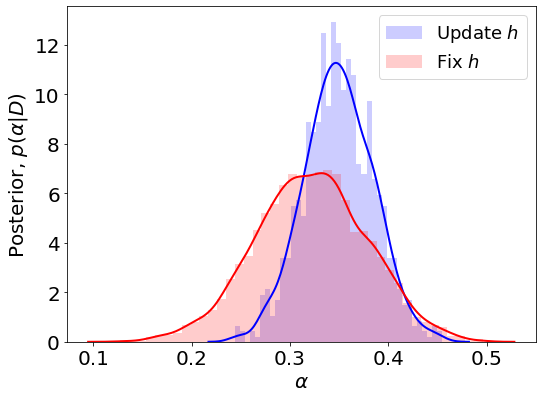

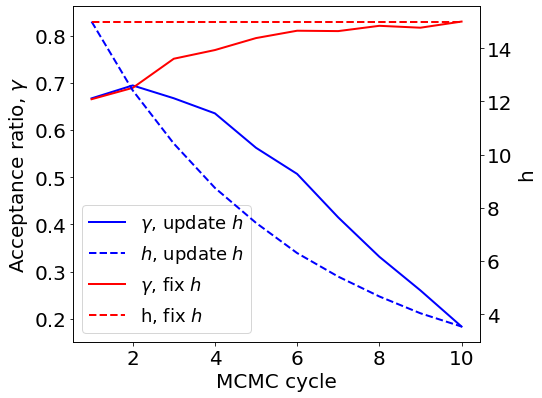

In [200]:
plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize


fig, ax = plt.subplots(figsize=(8,6))
plot_posterior(ax, alphas_update_h[-1], r'Update $h$',i,10, color='b')
plot_posterior(ax, alphas_fix_h[-1], r'Fix $h$',i,10, color='r')
plt.savefig('figures/h_posterior.png')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(8,6))
t1 = np.arange(cycles) +1
p1 = ax.plot(t1,acc_uh, c='b', linewidth=2, label=r'$\gamma$, update $h$')
ax2 = ax.twinx()
p2 = ax2.plot(t1,hs_uh, c='b', linewidth=2, linestyle='--', label='$h$, update $h$')
p3 = ax.plot(t1,acc_fh, c='r', linewidth=2, label=r'$\gamma$, fix $h$')
p4 = ax2.plot(t1,hs_fh, c='r', linewidth=2, linestyle='--', label=r'h, fix $h$')

ax2.set_ylabel('h')
ax.set_ylabel('Acceptance ratio, $\gamma$')
ax.set_xlabel('MCMC cycle')
lns = p1+p2+p3+p4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='best')
# ax.yaxis.label.set_color('b')
# ax2.yaxis.label.set_color('r')
# ax.tick_params(axis='y', colors='b')
# ax2.tick_params(axis='y', colors='r')
plt.tight_layout()
plt.savefig('figures/h_evolution.png')


# Investigate kernel

In [32]:
nData = 10
# y_obs,_ = gen_data(nData, alpha = 0.2)
y_obs = gen_exp_data(nData)

statistic = ['KL','WSD','ED','euc','mean', 'std', 'mean_std', 'NN_no_s']
hs = [50, 20, 3, 0.5, 2, 5, 5, 0.2]
max_iter=500
prior = sc.stats.uniform(0,0.5)
alphas = []
accs = []
mean_alphas = []
std_alphas = []
cycles = 10

for i, h in enumerate(hs):
    alpha, acc, _, prior1 = cycles_MCMC(y_obs, s_std, alpha_std,
                                         prior=prior, max_iter = max_iter, h=h,
                                         case=1, cycles=cycles, plot=False, statistic = statistic[i])
    alphas.append(alpha[-1])
    accs.append(acc)
    
    mean = []
    std = []
    for j in range(cycles):
        mean.append(np.mean(alpha[j]))
        std.append(np.std(alpha[j]))
    mean_alphas.append(mean)
    std_alphas.append(std)



KL: 0.359 +- 0.0430
WSD: 0.322 +- 0.0511
ED: 0.315 +- 0.0552
euc: 0.283 +- 0.0457
mean: 0.260 +- 0.0385
std: 0.330 +- 0.0344
mean_std: 0.331 +- 0.0232
NN_no_s: 0.347 +- 0.0189


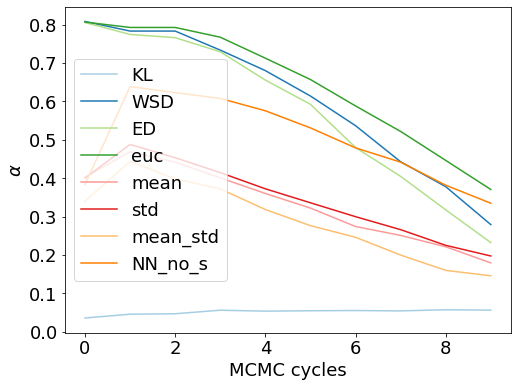

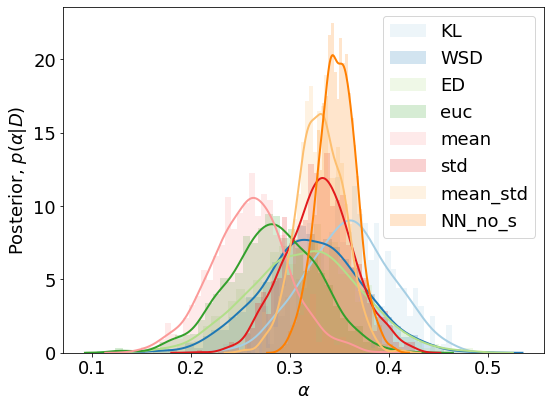

In [33]:
fig,ax = plt.subplots(figsize=(8,6))
fig2,ax2 = plt.subplots(figsize=(8,6))

cpalette = sns.color_palette("Paired", cycles)
t1 = np.arange(cycles) + 1

for i, a in enumerate(accs):
    plot_posterior(ax2, alphas[i], statistic[i],i,10)
    color = cpalette[i]
    ax.plot(a, label = statistic[i], c=color)
    print(f'{statistic[i]}: {np.mean(alphas[i]):.3f} +- {np.std(alphas[i]):.4f}')
    ma = np.array(mean_alphas[i])
    sa = np.array(std_alphas[i])
#     ax.plot(t1, ma, c=color, marker='.', markersize=12, label=statistic[i])
#     ax.fill_between(t1, y1=ma-sa, y2=ma+sa, alpha=0.2, color=color)
ax.set_xlabel('MCMC cycles')
ax.set_ylabel(r'$\alpha$')
ax.legend()
# plt.savefig('figures/')

# vary ndata fore naive

In [21]:
nDatas = [1, 10, 100, 1000]

statistic = 'NN_no_s'
h = 0.2
prior = sc.stats.uniform(0,0.5)
alphas = []
accs = []

for nData in nDatas:
    max_iter = int(10000/nData)
#     y_obs,_ = gen_data(nData, alpha = 0.2)
    y_obs = gen_exp_data(nData)
    alpha, acc, _, prior1 = cycles_MCMC(y_obs, s_std, alpha_std,
                                         prior=prior, max_iter = max_iter, h=h,
                                         case=1, cycles=10, plot=False, statistic = statistic)
    alphas.append(alpha[-1])
    accs.append(acc)


NN_no_s: 0.357 +- 0.0170
NN_no_s: 0.342 +- 0.0167
NN_no_s: 0.341 +- 0.0164


No handles with labels found to put in legend.


NN_no_s: 0.346 +- 0.0168


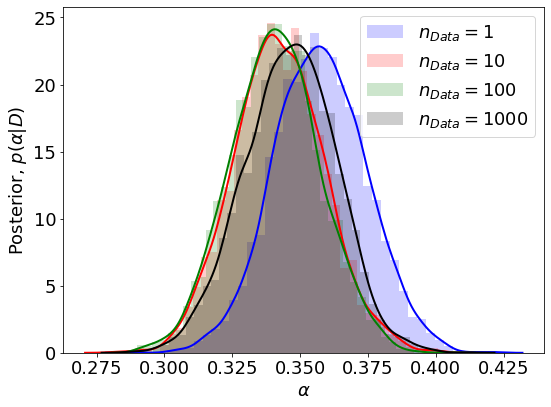

In [22]:
fig2,ax2 = plt.subplots(figsize=(8,6))
colors = ['b', 'r', 'g', 'k']
for i, a in enumerate(nDatas):
    plot_posterior(ax2, alphas[i], r'$n_{Data} = $' + f'{a}',i,len(nDatas), color=colors[i])
    
    
    print(f'{statistic}: {np.mean(alphas[i]):.3f} +- {np.std(alphas[i]):.4f}')
ax.legend()
plt.tight_layout()
plt.savefig('figures/data_naive.png')

#### Improved data

In [16]:
nDatas = [1, 10, 100]

statistic = 'NN'
h = 0.2
prior = sc.stats.uniform(0,0.5)
alphas = []
accs = []
miter = [2000,2000,2000,1000]

for i,nData in enumerate(nDatas):
#     max_iter = int(80000/nData)
    max_iter = miter[i]
#     y_obs,_ = gen_data(nData, alpha = 0.2)
    y_obs = gen_exp_data(nData)
    alpha, acc, _, prior1 = cycles_MCMC(y_obs, s_std, alpha_std,
                                         prior=prior, max_iter = max_iter, h=h,
                                         case=2, cycles=10, plot=False, statistic = statistic)
    alphas.append(alpha[-1])
    accs.append(acc)


NN: 0.307 +- 0.0137
NN: 0.355 +- 0.0092


No handles with labels found to put in legend.


NN: 0.346 +- 0.0083


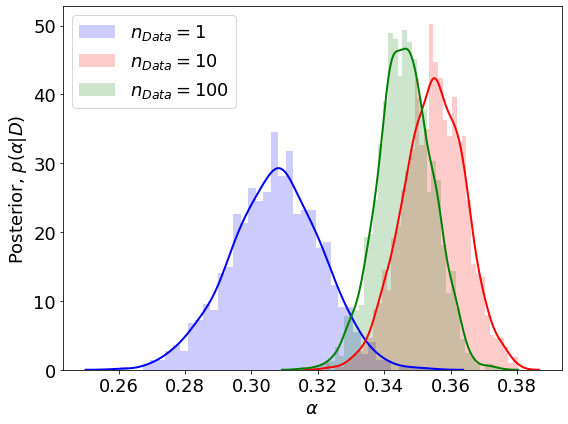

In [17]:
fig2,ax2 = plt.subplots(figsize=(8,6))
colors = ['b', 'r', 'g', 'k']
for i, a in enumerate(nDatas):
    plot_posterior(ax2, alphas[i], r'$n_{Data} = $' + f'{a}',i,len(nDatas), color=colors[i])
    print(f'{statistic}: {np.mean(alphas[i]):.3f} +- {np.std(alphas[i]):.4f}')
ax.legend()
plt.tight_layout()
plt.savefig('figures/data_improved.png')

# investigate better data

In [19]:
def cycles_MCMC(y_obs, s_std, alpha_std, prior, max_iter=100, h=0.5,updateh = True, case=1, cycles=1, plot=False,statistic = 'NN'):
    
    alphas = []
    acc_rat = []
    hs = []
    if plot:
        fig,ax = plt.subplots(figsize = (8,6))
    
    for i in tqdm(range(cycles)):
        if case == 1:
            alpha = ABC_MCMC(y_obs, prior, h=h, statistic=statistic, max_iter=max_iter, s_std = s_std, alpha_std=alpha_std)
            acc_ratio = alpha.shape[0] / (y_obs.shape[0]*max_iter)
        elif case== 2:
            alpha = ABC_MCMC2(y_obs, prior, h=h, statistic=statistic, max_iter=max_iter, s_std = s_std, alpha_std=alpha_std)
            acc_ratio = alpha.shape[0] / (max_iter)
        prior = sc.stats.norm(loc=np.mean(alpha), scale=np.std(alpha))
        if plot and (i%5==0 or i==cycles-1):
            plot_posterior(ax, alpha, f'{i}', i, cycles,plot_ci=i==cycles-1)
        if not i==0 and updateh:
            h = h/(1 + 0.2*(acc_ratio/(acc_rat[-1])))
        hs.append(h)
        acc_rat.append(acc_ratio)
        alphas.append(alpha)
    return alphas, acc_rat, hs, prior




nData = 1000
mcmc1_file = f'saved_structures/mcmc1_nData={nData}_no_s.p'
if os.path.isfile(mcmc1_file):
    print('Loading pickled MCMC1 data')
    data = pickle.load(open( mcmc1_file, "rb" ))
    y_obs, alphas1, acc1, hs1, prior1 = data
else:
    print('Generating MCMC1 data')
    max_iter = 1000
    h = 0.1
    statistic = 'NN_no_s'
    # y_obs,_ = gen_data(nData, alpha = 0.2)
    y_obs = gen_exp_data(nData)
    prior = sc.stats.uniform(loc=0, scale=0.5)
    alphas1, acc1, hs1, prior1 = cycles_MCMC(y_obs, s_std, alpha_std, statistic=statistic, prior=prior, max_iter = max_iter, h=h, case=1, cycles=10, plot=True)
    data = (y_obs, alphas1, acc1, hs1, prior1)
    pickle.dump(data, open(mcmc1_file, "wb"))

Loading pickled MCMC1 data


In [19]:
# Then run MCMC 2 with alst post as prior
# nData = 100
# y_obs = gen_exp_data(nData) # Remove these two!
mcmc2_file = f'saved_structures/mcmc2_nData={1000}.p'
if os.path.isfile(mcmc2_file):
    print('Loading pickled MCMC2 data')
    data = pickle.load(open( mcmc2_file, "rb" ))
    alphas2, acc2, hs2, prior2 = data
else:
    print('Generating MCMC2 data')
    h=0.02
    max_iter=2000
    alphas2, acc2, hs2, prior2 = cycles_MCMC(y_obs, s_std, alpha_std, prior=prior1, max_iter = max_iter, h=h, case=2, cycles=20, plot=True, statistic='NN')
    data = (alphas2, acc2, hs2, prior2)
    pickle.dump(data, open(mcmc2_file, "wb"))

Loading pickled MCMC2 data


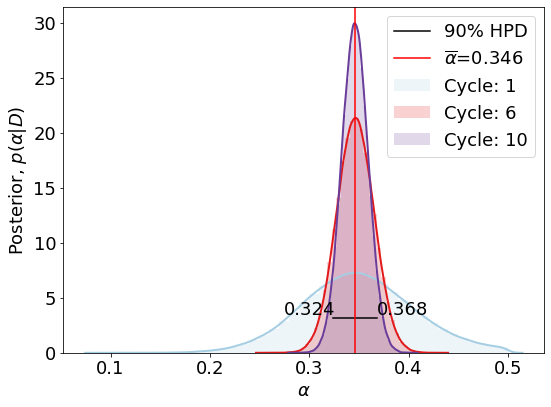

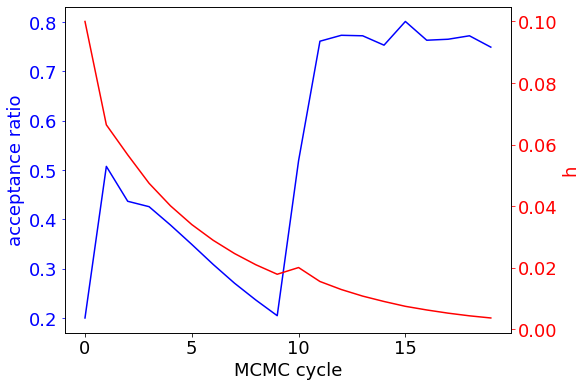

In [25]:
acc_rat = np.concatenate([acc1, acc2])
hs = np.concatenate([hs1, hs2])

fig,ax = plt.subplots(figsize=(8,6))
for i,a in enumerate(alphas1):
    if i%5 == 0:
        plot_posterior(ax, a, f'Cycle: {i+1}',i,10)
    elif i==9:
        plot_posterior(ax, a, f'Cycle: {i+1}',i,10, plot_ci=True)
plt.savefig('figures/naive_posterior.png')
        

fig, ax = plt.subplots(figsize=(8,6))
p1, = ax.plot(acc_rat, c='b', label='acceptance ratio')
ax2 = ax.twinx()
p2, = ax2.plot(hs, c='r', label='h')

ax2.set_ylabel('h')
ax.set_ylabel('acceptance ratio')
ax.set_xlabel('MCMC cycle')
ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
    

0.3458426835930405 0.001047038283238497
CI for alpha - MCMC1: 0.346 +- 0.0133
CI for alpha - MCMC2: 0.346 +- 0.0010


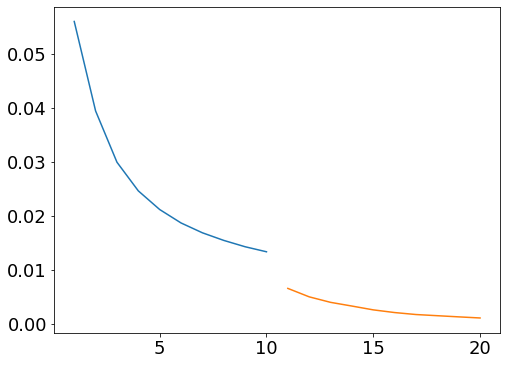

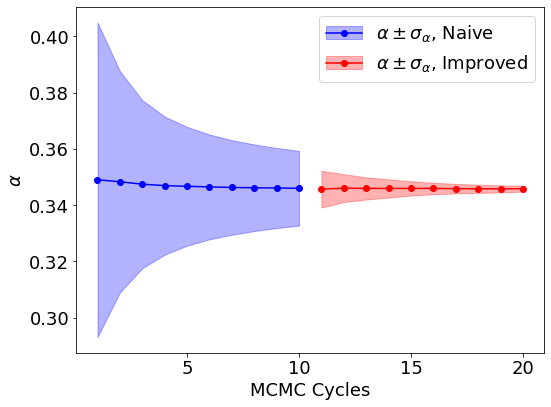

In [31]:
print(np.mean(alphas2[-1]), np.std(alphas2[-1]))
print(f'CI for alpha - MCMC1: {np.mean(alphas1[-1]):.3f} +- {np.std(alphas1[-1]):.4f}')
print(f'CI for alpha - MCMC2: {np.mean(alphas2[-1]):.3f} +- {np.std(alphas2[-1]):.4f}')

fig, ax = plt.subplots(figsize=(8,6))
mean1 = []
std1 = []
mean2 = []
std2 = []
t1 = []
t2 = []
for i,a in enumerate(alphas1):
    mean1.append(a.mean())
    std1.append(a.std())
    t1.append(i+1)

for i,a in enumerate(alphas2):
    mean2.append(a.mean())
    std2.append(a.std())
    t2.append(i+len(alphas1)+1)

ax.plot(t1,std1)
ax.plot(t2,std2)
    
fig, ax = plt.subplots(figsize=(8,6))
mean1 = np.array(mean1)
mean2 = np.array(mean2)
std1 = np.array(std1)
std2 = np.array(std2)
# ax.errorbar(t1, y = mean1, yerr = std1, c='b')
# ax.errorbar(t2, y = mean2, yerr = std2, c='r')
m1, = ax.plot(t1, mean1, c='b', marker='.', markersize=12)
m2, = ax.plot(t2, mean2, c='r', marker='.', markersize=12)
ci1 = ax.fill_between(t1, y1=mean1-std1, y2=mean1+std1, alpha=0.3, color='b')
ci2 = ax.fill_between(t2, y1=mean2-std2, y2=mean2+std2, alpha=0.3, color='r')
ax.set_xlabel('MCMC Cycles')
ax.set_ylabel(r'$\alpha$')
ax.legend([(m1, ci1), (m2, ci2)], [ r'$\alpha \pm \sigma_{\alpha}$, Naive', r'$\alpha \pm \sigma_{\alpha}$, Improved'], loc='best')
plt.tight_layout()
plt.savefig('figures/improved_ci.png')

yobs = 10, maxiter=2000, no updating of h: CI: 0.31-0.37
yobs = 10, maxiter=2000, updating with h: C: 0.33-0.36

Best result CI 0.14-0.26, max_iter = 1000, h = 0.05

In [ ]:
def ABC_MCMC(y_obs, gen_alpha = "prior", max_iter = 50, sim_iter=1, s_std = 0.01, alpha_std = 0.01):
    alpha = []
    N = y_obs[0,:].sum()
    for i, y_ob in tqdm(enumerate(y_obs)):
        theta_m = model.predict(y_ob.reshape(1,32)/N)[0]
        s_m = theta_m[1]
        alpha_m = theta_m[0]
        
        
        
        for j in range(max_iter):
#             start_time = time.time()
            s_star = np.random.normal(loc = s_m, scale  = s_std)
            
            if gen_alpha == "NN":
                # Use NN for alpha
                alpha_star = np.random.normal(loc = alpha_m, scale  = alpha_std)
                y_star = simulator(alpha_star, s_star)
                kern = kernel(y_star, y_ob)

                norm = sc.stats.norm(loc=alpha_m, scale = alpha_std)
                M1 = norm.pdf(0)
                M2 = norm.pdf(0.5)
                M = 2*max((1/M1,1/M2))*1
                M=1

                p_acc = kern*2/(M*norm.pdf(alpha_star))
                #print(p_acc, M, M1, M2)
                
            else:
                # Use prior for alpha
                alpha_star = np.random.rand()*0.5  
                y_star = simulator(alpha_star, s_star, n=1000*sim_iter)
                y_star /= sim_iter
#                 start_time2 = time.time()
                kern = kernel(y_star, y_ob, h=0.05, statistic = "NN")
#                 print("--- %s seconds ---" % (time.time() - start_time2))
                p_acc = kern
            
            if(np.random.rand() < p_acc):
                alpha.append(alpha_star) 
#             print("--- %s seconds ---" % (time.time() - start_time))
    return np.array(alpha) 